In [56]:
import numpy as np
import pickle as pickle
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Optional, List
from moseq2_nlp.models import DocumentEmbedding
from moseq2_nlp.data import load_groups, get_embedding_representation, get_transition_representations_n, sample_markov_chain
from moseq2_nlp.train import train_regressor, train_svm
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import lil_matrix
import pdb
from tqdm import tqdm
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

https://github.com/dattalab/moseq-drugs
https://www.nature.com/articles/s41593-020-00706-3.pdf

In [2]:
data_dir = '/cs/labs/mornitzan/ricci/data/abraira/moseq-drugs'
fns = ['dataset.pkl','fingerprints.pkl','syllablelabels.pkl']
content_dict = {'dataset':None, 'fingerprints':None, 'syllables':None}

for key, fn in zip(content_dict.keys(),fns):
    full_path = os.path.join(data_dir,fn)
    with open(full_path, 'rb') as pickle_file:
        content_dict[key] = pickle.load(pickle_file, encoding='latin1')

In [3]:
# Load the labels into our dataset array
split_points = np.cumsum([len(v['data']) for v in content_dict['dataset'].values()])[:-1]
split_syllable_labels = np.array_split(content_dict['syllables'],split_points)
for mouse_name,_syllable_labels in zip(content_dict['dataset'].keys(),split_syllable_labels):
    content_dict['dataset'][mouse_name]['syllable_labels'] = _syllable_labels

In [10]:
split_syllable_labels = np.where(np.isnan(split_syllable_labels), -5, split_syllable_labels)

In [138]:
labels = []
current_label = -1
current_drug = ""
current_dose = ""
label_by_dose_and_drug = False
all_drugs = []
all_drug_doses = []
for key in content_dict['dataset'].keys():
    split_key = key.split('_')
    dose, drug = split_key[1], split_key[2]
    if 'mgkg' not in dose:
        if 'mgkg' in split_key[2]:
            dose = split_key[2]
            drug = split_key[1]
        elif 'control' or 'second' in dose:
            dose = '0'
            drug = 'control'
        elif 'saline' in dose:
            dose = '0'
            drug = 'saline'
    if drug not in all_drugs:
        all_drugs.append(drug)
        current_label +=1
    if dose + drug not in all_drug_doses and label_by_dose_and_drug:
        all_drug_doses.append(dose + drug)
        current_label += 1
    labels.append(current_label)
unique_labels = list(range(labels[-1] + 1))

In [35]:
sentences = []
for ssl in split_syllable_labels:
    sentences.append([str(int(s)) for s in ssl])

In [36]:
documents = [TaggedDocument(sent, [i]) for i, sent in enumerate(sentences)]

In [155]:
dim = 300 #max_syllable # Dimension of embedding space
window = 2 # Window size for context (this is left and right, so total size is 2*window)

# Initialize and train two models on the documents. Embeddings will be averaged, which is standard. 
# Note: min_count = <min_count> omits words with usages less than <min_count>
print('Training dm=1')
model1 = Doc2Vec(documents, dm=1, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Training dm=0')
model2 = Doc2Vec(documents, dm=0, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Done')

Training dm=1
Training dm=0
Done


In [156]:
# Infer embeddings per document per model and then average. 
E1 = [model1.infer_vector(sent) for sent in sentences]
E2 = [model2.infer_vector(sent) for sent in sentences]
E = [.5 * (em1 + em2) for (em1, em2) in zip(E1, E2)]

## Visualize

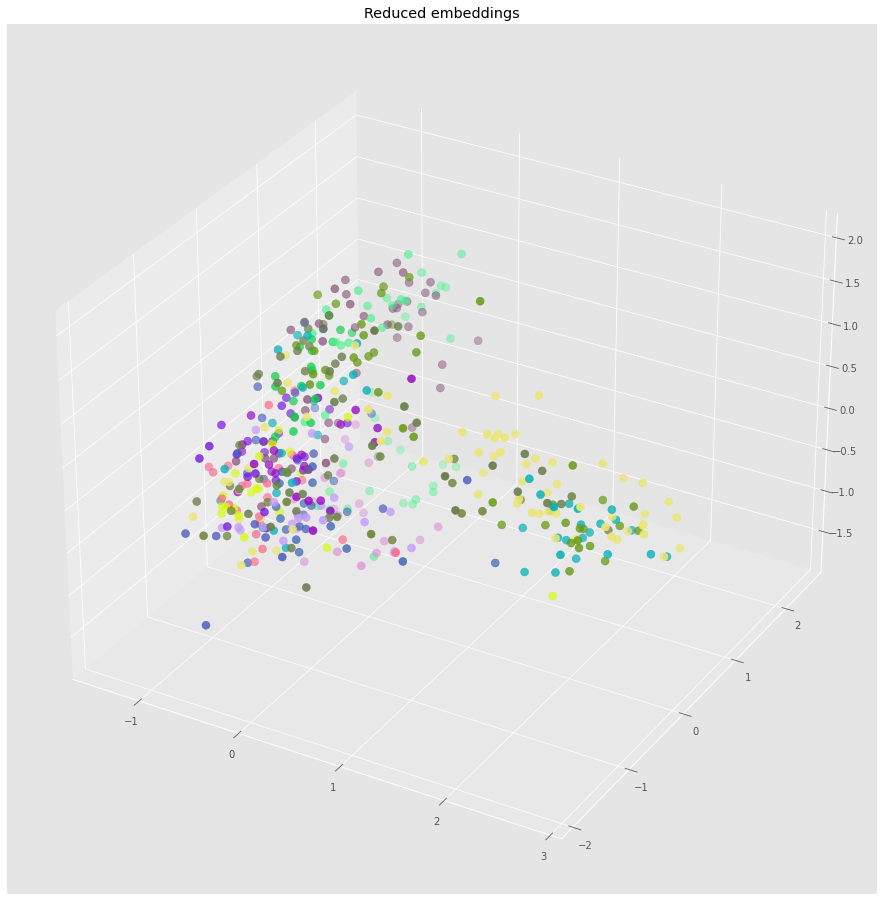

In [157]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
which_model = 'pca'
n_components = 50

if which_model == 'pca':
    model = PCA(n_components=n_components)
else:
    model = TSNE(n_components=n_components, perplexity=150)
out = model.fit_transform(E)

unique_colors = np.random.rand(len(unique_labels),3)
colors = [unique_colors[lb] for lb in labels]

if n_components == 2:
    fig, ax = plt.subplots(figsize=(16,16))
    plt.scatter(out[:,0], out[:,1],c=colors)

elif n_components > 2:
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(out[:,0], out[:,1], out[:,2],c=colors, s=64)
else:
    print('Need more dimensions!')

ax.set_title('Reduced embeddings')
plt.show()
plt.close()

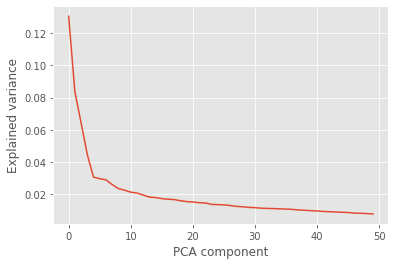

In [158]:
plt.plot(model.explained_variance_/model.explained_variance_.sum())
plt.xlabel('PCA component')
plt.ylabel('Explained variance')
plt.show()

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

seed = 22
C = 1e1
X_train, X_test, y_train, y_test = train_test_split(E, labels, test_size=0.33, random_state=seed)

clf = LogisticRegression(random_state=0, penalty='l2',C=C, max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print((np.array(y_test)==y_pred).mean())

0.5120481927710844
